In [1]:
using HDF5
using Printf
using DataFrames
using CSV
using ArgParse
using Random
using LinearAlgebra
using VQE

using Flux 
#using GeometricFlux 
using Graphs
using Statistics
#using GeometricFlux: GraphConv
#using GraphSignals
#using GeometricFlux: edge_list_graph

using PyPlot
using Zygote
using GraphNeuralNetworks
using SimpleWeightedGraphs 
using Revise
using MLUtils
using Flux: DataLoader
using Flux.Losses: logitbinarycrossentropy, binarycrossentropy
using Flux: @functor

In [ ]:
N = 10

PATH = @sprintf("/home/ubuntu/aqc_QAOA/SpinFluctuations.jl/data/N_%i/", N);
#file_name = PATH * @sprintf("hard_random_SK_instance_N_%i_seed_%i.h5", N , seed)
#J_mat = h5read(file_name, "couplings"); 
#local_fields = h5read(file_name, "local_fields")


PATH_t = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", N);

PATH_N10 = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", 10);
PATH_N12 = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", 12);
PATH_N14 = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", 14);
PATH_N16 = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", 16);
PATH_N18 = @sprintf("/home/ubuntu/aqc_GNN/SK_data/N_%i/", 18);

In [3]:
function load_single_instance(file_path::String, n::Int)
    
    J = h5read(file_path, "couplings"); 
    local_fields = h5read(file_path, "local_fields")
    bitstring = h5read(file_path, "solution_bitstring")

    # Create DataFrame for the single instance
    df = DataFrame()
    
    # add ground state energy
    df[!, Symbol("solution_bitstring")] = [bitstring]

    # Add local fields columns
    for i in 1:n
        df[!, Symbol("h$i")] = [local_fields[i]]
    end
    
    # Add couplings matrix columns (upper triangle only)
    for i in 1:n
        for j in i+1:n
            df[!, Symbol("J_$(i)_$(j)")] = [J[i, j]]
        end
    end

    return df
end


function load_dataset(instance_files::Vector{String}, n::Int)
    all_instances = DataFrame()
    #instance_files = PATH * instance_files
    #params_files = PATH_params * params_files

    for (instance_path) in instance_files
        df = load_single_instance(instance_path, n)
        
        # Append to the main DataFrame
        append!(all_instances, df)

    end

    return all_instances
end



function df_to_training_data(df::DataFrame, N::Int)
    training_data = []

    for row in eachrow(df)
        # 1. Extract h vector
        h = [row[Symbol("h$i")] for i in 1:N]

        # 2. Build full symmetric J matrix from upper triangle
        J = zeros(N, N)
        for i in 1:N
            for j in i+1:N
                key = Symbol("J_$(i)_$(j)")
                J[i, j] = row[key]
                J[j, i] = row[key]
            end
        end

        # 3. Extract solution bitstring and convert to Float32
        z = Float32.(row.solution_bitstring)
        J = Float32.(J)
        h = Float32.(h)

        # 4. Append (J, h, z) tuple
        push!(training_data, (J, h, z))
    end

    return training_data
end

df_to_training_data (generic function with 1 method)

In [4]:
instance_files = readdir(PATH_N10)
instance_files = instance_files[1:1000]
full_path_instance = [joinpath(PATH_N10, file) for file in instance_files]
df_10 = load_dataset(full_path_instance, 10)


instance_files = readdir(PATH_N12)
instance_files = instance_files[1:1000]
full_path_instance = [joinpath(PATH_N12, file) for file in instance_files]
df_12 = load_dataset(full_path_instance, 12)



instance_files = readdir(PATH_N14)
instance_files = instance_files[1:1000]
full_path_instance = [joinpath(PATH_N14, file) for file in instance_files]
df_14 = load_dataset(full_path_instance, 14)


instance_files = readdir(PATH_N16)
instance_files = instance_files[1:250]
full_path_instance = [joinpath(PATH_N16, file) for file in instance_files]
df_16 = load_dataset(full_path_instance, 16)


instance_files = readdir(PATH_N18)
instance_files = instance_files[1:110]
full_path_instance = [joinpath(PATH_N18, file) for file in instance_files]
df_18 = load_dataset(full_path_instance, 18)


Row,solution_bitstring,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,J_1_2,J_1_3,J_1_4,J_1_5,J_1_6,J_1_7,J_1_8,J_1_9,J_1_10,J_1_11,J_1_12,J_1_13,J_1_14,J_1_15,J_1_16,J_1_17,J_1_18,J_2_3,J_2_4,J_2_5,J_2_6,J_2_7,J_2_8,J_2_9,J_2_10,J_2_11,J_2_12,J_2_13,J_2_14,J_2_15,J_2_16,J_2_17,J_2_18,J_3_4,J_3_5,J_3_6,J_3_7,J_3_8,J_3_9,J_3_10,J_3_11,J_3_12,J_3_13,J_3_14,J_3_15,J_3_16,J_3_17,J_3_18,J_4_5,J_4_6,J_4_7,J_4_8,J_4_9,J_4_10,J_4_11,J_4_12,J_4_13,J_4_14,J_4_15,J_4_16,J_4_17,J_4_18,J_5_6,J_5_7,J_5_8,J_5_9,J_5_10,J_5_11,J_5_12,J_5_13,J_5_14,J_5_15,J_5_16,J_5_17,J_5_18,J_6_7,J_6_8,J_6_9,J_6_10,J_6_11,J_6_12,⋯
,Array…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1]",-0.214512,-0.0168925,0.0553711,0.020215,-0.159298,-0.00972836,0.0134169,-0.118284,0.343975,0.399925,0.282185,0.0100376,0.125703,-0.306236,-0.0527126,-0.244208,0.109382,-0.379967,0.12211,-0.0125804,0.159007,0.0199876,0.323507,-0.12745,-0.275039,-0.248147,0.324381,-0.00728954,0.090855,-0.170609,-0.20335,-0.0334897,0.0856001,-0.352202,0.428608,-0.0369815,-0.218739,-0.140746,-0.150689,0.000869455,0.199631,-0.0506724,0.49244,-0.0194498,0.155232,-0.147734,-0.0433201,0.233079,-0.0553495,-0.167702,0.263868,-0.0969398,-0.0942787,-0.162952,-0.082128,-0.569773,0.253333,-0.121807,-0.0627912,-0.299329,-0.03466,-0.132657,0.072208,0.0600892,0.0708228,0.0837733,-0.0177811,-0.475039,-0.150313,-0.282384,-0.177636,0.225317,-0.00934095,0.206731,-0.0714246,-0.181637,0.265697,-0.00999374,0.0948744,-0.0218619,0.472905,0.293062,0.0995902,-0.46958,-0.0438894,0.379703,0.104905,0.119883,-0.128355,-0.0859152,-0.113679,0.112252,0.141476,-0.149477,-0.104621,-0.314964,-0.216807,-0.479975,-0.452766,⋯
2,"[1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1]",0.106753,-0.225297,-0.475491,-0.166563,-0.14788,-0.0369566,-0.112992,-0.116953,-0.00381648,0.247887,0.25277,0.146521,0.230177,0.0443309,-0.19714,0.188582,0.225624,0.259727,-0.115416,-0.0299096,0.12093,0.0949483,-0.0396983,0.234895,-0.415786,0.0775892,0.227313,-0.207241,0.0672635,0.198475,0.210525,0.0453683,0.096846,-0.231228,0.0574569,-0.212339,-0.455659,0.0488703,-0.330039,0.269982,0.0407456,0.225744,-0.309599,0.0384447,-0.0778519,-0.00737599,-0.137833,0.0370543,0.154176,-0.0489771,-0.0329962,0.226925,-0.0901694,0.205194,-0.057103,-0.468436,-0.0585882,0.0960976,-0.0770651,-0.148032,0.261393,0.144371,0.294825,0.0933984,-0.171133,0.195177,-0.0606871,-0.196997,0.602268,-0.0274672,-0.322717,0.0748003,-0.177531,0.154533,-0.0402949,0.188167,-0.511376,-0.0959393,0.0317111,-0.0272482,0.0267266,-0.0656021,0.0791182,0.272933,0.0834908,-0.15158,0.00245801,-0.184193,0.279729,0.0730117,0.0175203,0.0844746,0.181544,0.0509974,-0.157017,0.119912,-0.000575304,0.086466,-0.146614,⋯
3,"[1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1]",0.0292899,0.168209,0.0203897,0.122556,-0.240391,-0.0873846,-0.178187,-0.440332,0.151174,0.373119,-0.264526,0.0596953,-0.639202,-0.0628888,0.056332,-0.202838,-0.135157,0.200547,-0.250348,0.247286,0.109038,0.219723,-0.353045,-0.119218,0.157604,0.314597,-0.117797,-0.0654911,0.0758043,0.0774381,0.144601,-0.354119,0.0119867,-0.0346138,-0.0999496,-0.141751,-0.09991,-0.0715964,0.303439,0.0648983,-0.270578,0.0511189,-0.

In [ ]:
#training_data = df_to_training_data(df, N)

training_data_10 = df_to_training_data(df_10, 10)
training_data_12 = df_to_training_data(df_12, 12)
training_data_14 = df_to_training_data(df_14, 14)
training_data_16 = df_to_training_data(df_16, 16)
training_data_18 = df_to_training_data(df_18, 18)


#println(training_data_14[1])

In [ ]:
function to_gnn(distance_matrix, node_features, targets)
    # Get all possible edges (including self-loops)
    n = size(distance_matrix, 1)
    rows, cols = Int[], Int[]
    edge_weights = Float32[]
    
    for i in 1:n, j in 1:n
        # Skip if you want to avoid self-loops: i ≠ j
        push!(rows, i)
        push!(cols, j)
        push!(edge_weights, distance_matrix[i,j])
    end

    
    # Create GNNGraph with edge features
    g = GNNGraph((rows, cols, edge_weights), 
                #ndata=(; x=reshape(node_features, :, 1),  # Node features
                #      y=reshape(targets, :, 1)),         # Targets
                ndata = (
                    x = reshape(Float32.(node_features), 1, n),           # 1 × N
                    y = reshape(Float32.(targets), 1, n)            # 1 × N   (target!)
                )
                #edata=(weights = edge_weights)
                )  # Edge features!
    
    return g
end

to_gnn (generic function with 1 method)

In [ ]:
function check_test_data(data, num_data, model)

    for i in 1:num_data
            
        J, h, spins = data[i]
        J = Float32.(J)
        h = Float32.(h)
        #model = SKGNN()
        pred = model(J, h)

        println(spins)
        println(pred)

        println("True energy: ", -dot(h, spins) - 0.5 * dot(spins, J * spins))
        println("Pred energy: ", -dot(h, pred) - 0.5 * dot(pred, J * pred))

    end

end

check_test_data (generic function with 1 method)

In [ ]:
function check_test_data_save(data, num_data, model, N)
    #num_data = 100 

    PATH = @sprintf("/home/ubuntu/aqc_GNN/SK_data/result_data/N_%i/", N)

    for i in 1:num_data
        
        idx = i
        J, h, spins = data[i]
        J = Float32.(J)
        h = Float32.(h)
        #model = SKGNN()
        pred = model(J, h)

        println(spins)
        println(pred)
        
        true_e = -dot(h, spins) - 0.5 * dot(spins, J * spins)
        pred_e = -dot(h, pred) - 0.5 * dot(pred, J * pred)

        println("True energy: ", true_e)
        println("Pred energy: ", pred_e)

        h5open(PATH * @sprintf("optimized_GNN_instance_N_%i_idx_%i.h5", N, idx), "w") do file
            write(file, "true_energy", pred_e)           
            write(file, "true_spins", spins)                               
            write(file, "pred_energy", true_e)                    
            write(file, "pred_spins", pred)           
        end

    end

end

function round_spin(x)
    if x > 0
        return 1
    else
        return -1
    end
end

check_test_data_save (generic function with 1 method)

In [ ]:
# 1. Proper model definition with gradient tracking
struct SKGNN
    message_layers::Chain
    update_layer::Chain
    readout_layer::Chain
end

@functor SKGNN  # Essential for parameter tracking

function SKGNN(node_dim=1, edge_dim=1, hidden_dim=32)
    message_layers = Chain(
        Dense(2*node_dim + edge_dim, hidden_dim, tanh),  # Changed to tanh
        Dense(hidden_dim, hidden_dim, tanh),
        Dense(hidden_dim, node_dim)
    )
    
    update_layer = Chain(
        Dense(2*node_dim, hidden_dim, tanh),
        Dense(hidden_dim, node_dim)
    )
    
    readout_layer = Chain(
        Dense(node_dim, hidden_dim, relu),
        Dense(hidden_dim, 1, tanh)  # Bounded output
    )
    
    return SKGNN(message_layers, update_layer, readout_layer)
end


# 2. Gradient-safe forward pass
function (model::SKGNN)(J::Matrix{Float32}, h::Vector{Float32}, num_iters::Int=5)
    n = size(J, 1)
    # Initialize node features as regular arrays (not Params)
    node_features = [Float32[h[i]] for i in 1:n]  # Each feature is a 1-element vector
    
    for _ in 1:num_iters
        # Message passing
        messages = [
            sum([
                model.message_layers(vcat(node_features[i], node_features[j], [J[i,j]]))
                for j in 1:n if i ≠ j
            ]) ./ (n-1)
            for i in 1:n
        ]
        
        # Node update - keep as regular arrays
        node_features = [
            tanh.(node_features[i] .+ model.update_layer(vcat(node_features[i], messages[i])))
            for i in 1:n
        ]
    end
    
    # Readout
    spins = [model.readout_layer(feat)[1] for feat in node_features]
    return vcat(spins...)
end

"""
function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    #energy = -0.5f0 * dot(pred_spins, J * pred_spins) - dot(pred_spins, h)
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)

    binary_penalty = mean(abs.(pred_spins .^ 2 .- 1.0f0))
    return energy + 0.1f0 * binary_penalty
end


function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    
    # Energy term
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)
    
    # Binary penalty (more aggressive)
    binary_penalty = mean((pred_spins .^ 2 .- 1.0f0) .^ 2)
    
    # Add similarity to ground truth (if available)
    similarity = mean(abs.(pred_spins .- true_spins))
    
    return energy + 0.5f0 * binary_penalty + 0.1f0 * similarity
end
"""

function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    #energy = -0.5f0 * dot(pred_spins, J * pred_spins) - dot(pred_spins, h)
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)    
    energy_true = -dot(h, true_spins) - 0.5f0 * dot(true_spins, J * true_spins)

    energy_loss = (energy - energy_true)^2
    binary_penalty = mean(abs.(pred_spins .^ 2 .- 1.0f0))
    
    return energy_loss + 0.1f0 * binary_penalty
end


# 4. Training with gradient verification
function train_skgnn(model, data, epochs=100; lr=0.01)
    optimizer = ADAM(lr)
    ps = Flux.params(model)  # Get all trainable parameters
    
    for epoch in 1:epochs
        total_loss = 0.0f0
        for (J, h, true_spins) in data
            grads = gradient(ps) do
                sk_loss(model, J, h, true_spins)
            end

            # Proper gradient handling
            Flux.update!(optimizer, ps, grads)
            
            total_loss += sk_loss(model, J, h, true_spins)
        end
        avg_loss = total_loss / length(data)
        
        println("Epoch $epoch, Loss: $avg_loss")
        
        #if avg_loss < 0.1
        #    println("Converged!")
        #    break
        #end
    end
end


function train_skgnn_with_batch(model, data, epochs=100, lr=0.01, batchsize=32)
    optimizer = ADAM(lr)
    ps = Flux.params(model)

    N = length(data)
    loss_history = Float32[]  # Store average loss per epoch

    for epoch in 1:epochs
        total_loss = 0.0f0

        # Shuffle data for each epoch
        #Random.seed!(1234)
        #shuffled_indices = randperm(N)
        #data_shuffled = data[shuffled_indices]

        for batch_start in 1:batchsize:N
            batch_end = min(batch_start + batchsize - 1, N)
            batch = data[batch_start:batch_end]
            #batch = data_shuffled[batch_start:batch_end]

            grads = gradient(ps) do
                mean([sk_loss(model, J, h, spins) for (J,h,spins) in batch])
            end

            Flux.update!(optimizer, ps, grads)

            batch_loss = mean([sk_loss(model, J, h, spins) for (J,h,spins) in batch])
            total_loss += batch_loss
        end

        avg_loss = total_loss / ceil(Int, N / batchsize)
        push!(loss_history, avg_loss)  # Store epoch loss

        println("Epoch $epoch, Loss: $avg_loss")
    end

    return loss_history
end

train_skgnn_with_batch (generic function with 4 methods)

In [ ]:
"""
function main()
    # Create synthetic data
    data_1 = training_data_10[1:1000]
    data_2 = training_data_12[1:1000]
    data_3 = training_data_14[1:1000]
    data_4 = training_data_16[1:250]
    data_5 = training_data_18[1:110]

    data_combined = vcat(data_1, data_2, data_3)

    model = SKGNN()
    loss = train_skgnn_with_batch(model, data_1, 5, 0.01, 50)

    # Test data
    check_test_data(data_1, 100, model)
    #check_test_data(data_2, 200, model)
    #check_test_data(data_3, 200, model)
    #check_test_data(data_4, 100, model)

    return loss
end
"""
#losses = main()

In [ ]:
data_1 = training_data_10[1:1000]
data_2 = training_data_12[1:1000]
data_3 = training_data_14[1:1000]
data_4 = training_data_16[1:250]
data_5 = training_data_18[1:110]


data_combined = vcat(data_1, data_2, data_3, data_4, data_5)

Random.seed!(1234)
model = SKGNN()
loss = train_skgnn_with_batch(model, data_combined, 50, 0.0017, 50)


# Test data
#check_test_data(data_1, 100, model)
#check_test_data(data_2, 200, model)
#check_test_data(data_3, 200, model)
#check_test_data(data_4, 100, model)


Epoch 1, Loss: 40.021343
Epoch 2, Loss: 21.257605
Epoch 3, Loss: 18.244892
Epoch 4, Loss: 19.213915
Epoch 5, Loss: 18.048908
Epoch 6, Loss: 17.768028
Epoch 7, Loss: 17.41167
Epoch 8, Loss: 17.325119
Epoch 9, Loss: 17.294376
Epoch 10, Loss: 17.814194
Epoch 11, Loss: 16.915716
Epoch 12, Loss: 16.393229
Epoch 13, Loss: 16.842611
Epoch 14, Loss: 16.639256
Epoch 15, Loss: 16.180992
Epoch 16, Loss: 17.023727
Epoch 17, Loss: 15.67663
Epoch 18, Loss: 14.963586
Epoch 19, Loss: 14.22306
Epoch 20, Loss: 12.856877
Epoch 21, Loss: 9.826488
Epoch 22, Loss: 5.619186
Epoch 23, Loss: 4.394607
Epoch 24, Loss: 4.025661
Epoch 25, Loss: 6.515661
Epoch 26, Loss: 3.7618425
Epoch 27, Loss: 3.78048
Epoch 28, Loss: 3.3873997
Epoch 29, Loss: 2.8983638
Epoch 30, Loss: 5.266001
Epoch 31, Loss: 3.0769138
Epoch 32, Loss: 4.518067
Epoch 33, Loss: 3.0923057
Epoch 34, Loss: 4.1317925
Epoch 35, Loss: 3.4858208
Epoch 36, Loss: 3.1191902
Epoch 37, Loss: 3.2879794
Epoch 38, Loss: 3.3024158
Epoch 39, Loss: 4.171303
Epoch 40

50-element Vector{Float32}:
 40.021343
 21.257605
 18.244892
 19.213915
 18.048908
 17.768028
 17.41167
 17.325119
 17.294376
 17.814194
  ⋮
  3.629735
  3.1416085
  3.0564108
  3.5554953
  2.923842
  3.399116
  2.882871
  2.7962406
  4.3102517

In [ ]:
# Test on a sample

J, h, spins = data_1[1]
J = Float32.(J)
h = Float32.(h)
pred = model(J, h)

println(spins)
println(pred)

#pred = ceil.(Int, pred)
pred = round_spin.(pred)

#L = size(J,1)
#println("True energy: ", sum([-h[l] * spins[l] for l in 1:L]) + sum([-J[i, j] * spins[i] * spins[j] for i in 1:L for j in (i+1):L]) )
#println("Pred energy: ", sum([-h[l] * pred[l] for l in 1:L]) + sum([-J[i, j] * pred[i] * pred[j] for i in 1:L for j in (i+1):L]) )

println("True energy: ", -dot(h, spins) - 0.5 * dot(spins, J * spins))
println("Pred energy: ", -dot(h, pred) - 0.5 * dot(pred, J * pred))

In [ ]:
function energies_and_bitstrings_qaoa(annealing_problem)
    L = annealing_problem.num_qubits
    h = annealing_problem.local_fields
    J = annealing_problem.couplings
    
    bit_string_df = DataFrame( bit_string = [], energy = Float64[]);
    
    bitstrings = [string(i, base=2, pad=L) |> reverse for i in 0:(2^L - 1)]
    bitvals = [parse.(Int, [bitstring[j] for j in 1:L]) for bitstring in bitstrings]
    spins = [1 .- 2s for s in bitvals]
    
    for spin in spins
        energy = sum([-h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        push!(bit_string_df,[ spin, energy])
    end
    
    return bit_string_df
end


function check_test_data_and_compare(data, num_data, N)

    #PATH = @sprintf("/home/ubuntu/aqc_GNN/SK_data/result_data/N_%i/", N)
    energy_state_index_all = 0
    non_count_index = 0
    index_all = []
    
    for i in 1:num_data
        
        idx = i
        J, h, spins = data[i]
        J = Float32.(J)
        h = Float32.(h)
        pred = model(J, h)
        pred = round_spin.(pred)
        mf_problem = Problem(0, h, J);

        exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem)
        sorted_df = sort(exact_solution_bitstring, :energy)
        
        lowest_energy_rows = sorted_df[1:200, :]
        lowest_energy = sorted_df[1, :] 
        exact_bitstring = lowest_energy[1]
        

        # find the energy of a bitstring  
        target_bitstring = pred
        
        # Filter the DataFrame for the row containing the target bitstring
        matching_row = filter(row -> row.bit_string == target_bitstring, lowest_energy_rows)
        
        # Check if a match is found
        if nrow(matching_row) > 0
            #println("Matching bitstring found: ", matching_row)
            state_index = findfirst(row -> row[:bit_string] == target_bitstring, eachrow(lowest_energy_rows))
            state_index -= 1
            #println(state_index)
            push!(index_all, copy(state_index)) 
            energy_state_index_all += state_index 
            #println(energy_state_index_all)
        else
            #println("No matching bitstring found.")
            non_count_index += 1
        end
        

    end

    #println(total_num_inst)
    average_state_index = energy_state_index_all / (num_data - non_count_index)
    error_index = std(index_all)
    println("average energy state index: ", average_state_index)
    return average_state_index, index_all, error_index 

end

check_test_data_and_compare (generic function with 1 method)

In [ ]:
i10, iall_10, err10 = check_test_data_and_compare(data_1, 100, 10)
i12, iall_12, err12 = check_test_data_and_compare(data_2, 100, 12)
i14, iall_14, err14 = check_test_data_and_compare(data_3, 100, 14)
i16, iall_16, err16 = check_test_data_and_compare(data_4, 100, 16)
i18, iall_18, err18 = check_test_data_and_compare(data_5, 100, 18)

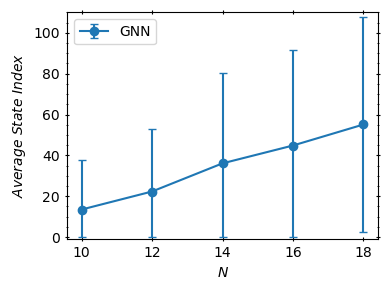

[13.5, 22.33, 36.11702127659574, 44.848837209302324, 55.13636363636363]
[24.312568973701854, 30.68940362648801, 44.03465311436856, 46.96920579219599, 52.503153418448306]


In [28]:
figure(figsize=(4, 3))

    
state_index = [i10, i12, i14, i16, i18]
index_errors = [err10, err12, err14, err16, err18]
x_values = [10, 12, 14, 16, 18]

println(state_index)
println(index_errors)

lower_errors = [min(e, yi) for (yi, e) in zip(state_index, index_errors)]  # max allowed drop is to 0
upper_errors = index_errors

errorbar(
    x_values,
    state_index,
    yerr=(lower_errors, upper_errors),  # Add errors for each parameter
    label="GNN",
    fmt="-o",  # Line with circular markers
    capsize=3  # Caps on error bars for clarity
    )


xlabel(L"N")
ylabel(L"Average \ State \ Index")
#title("Average VQE parameter for p=5: Transformed Instances", fontsize=11)
ylim(-1 , 110)

#xticks(10:2:18)
minorticks_on()
tick_params(direction="inout", top=true, right=true)
tick_params(axis="x", which="minor", bottom=false, top=false)
tick_params(axis="y", which="minor", direction="inout", right=true)
ax[:set_xticks]([10,12,14,16,18])

legend(loc="upper left")
#grid(true)
tight_layout()
savefig("/home/ubuntu/Results_master/GNN_average_index_SK.pdf", bbox_inches="tight")

display(gcf())

Loss Plot

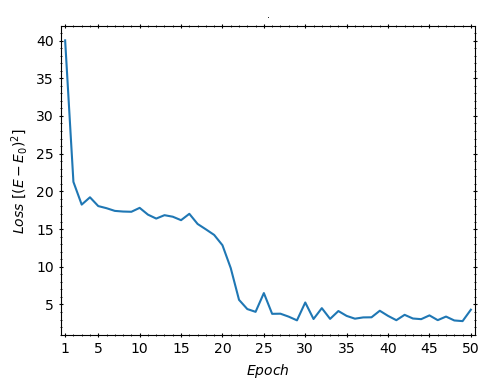

In [19]:
fig, ax = subplots(figsize=(5, 4))


#ax.plot(N_values, p, marker="o", color=colors[1], linestyle="-", label=L"VQE")

ax.plot(1:length(loss), loss, linestyle="-")


#plot(N_values_n, pv2, marker="o", color="blue", linestyle="-", label=L"VQE \ (N+3), \ starting \ N: \ 12")

ax.set_title(L".", fontsize=7)
#ax.legend(loc="upper right", fontsize=9)

ax.set_xlim(0.5, 50.5) 
#ax.set_ylim(0.5, 50.5) 

ax.minorticks_on()

ax.tick_params(axis="x", which="major", direction="inout", bottom=true, top=true)
ax.tick_params(axis="x", which="minor", direction="inout", bottom=true, top=true)
ax.tick_params(axis="y", which="minor", direction="inout", left=true, right=true)


# Y-axis label
ax.set_ylabel(L"Loss \ [(E - E_0)^2]", fontsize=10)
ax.set_xlabel(L"Epoch", fontsize=10)

# Shared X-axis label
ax[:set_xticks]([1,5,10,15,20,25,30,35,40, 45, 50])
#ax[:set_xticks]([1,5,10,15,20,25,30])


ax.tick_params(direction="inout", top=true, right=true)

tight_layout()

savefig("/home/ubuntu/Results_master/Loss_GNN_SK.pdf")

display(fig)

In [84]:
J, h, spins = training_data_10[1]
J = Float32.(J)
h = Float32.(h)

mf_problem = Problem(0, h, J);

exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem)

sorted_df = sort(exact_solution_bitstring, :energy)

top10_lowest_energy_row = sorted_df[1:15, :]
lowest_energy = sorted_df[1, :] 

println(top10_lowest_energy_row)

exact_bitstring = lowest_energy[1]

15×2 DataFrame
 Row │ bit_string                         energy   
     │ Any                                Float64  
─────┼─────────────────────────────────────────────
   1 │ [1, 1, -1, 1, -1, 1, 1, 1, 1, 1]   -6.75277
   2 │ [-1, 1, -1, -1, -1, -1, -1, -1, …  -6.66358
   3 │ [-1, 1, -1, -1, -1, -1, -1, -1, …  -6.5678
   4 │ [-1, 1, 1, -1, -1, -1, -1, -1, -…  -6.13579
   5 │ [-1, 1, -1, -1, 1, -1, -1, -1, -…  -5.36583
   6 │ [-1, 1, 1, -1, 1, -1, -1, -1, -1…  -5.25646
   7 │ [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]    -5.21089
   8 │ [-1, 1, 1, -1, -1, -1, -1, -1, -…  -5.17665
   9 │ [1, -1, -1, 1, -1, 1, 1, 1, 1, 1]  -5.14248
  10 │ [1, 1, -1, 1, -1, 1, 1, 1, 1, -1]  -5.13403
  11 │ [-1, 1, -1, 1, -1, -1, -1, -1, -…  -4.91273
  12 │ [1, -1, -1, 1, 1, 1, 1, 1, 1, 1]   -4.81598
  13 │ [1, 1, 1, 1, -1, 1, 1, 1, 1, -1]   -4.64707
  14 │ [-1, 1, -1, 1, 1, 1, 1, 1, 1, 1]   -4.61804
  15 │ [-1, 1, -1, 1, -1, 1, 1, 1, 1, 1]  -4.58417


10-element Vector{Int64}:
  1
  1
 -1
  1
 -1
  1
  1
  1
  1
  1